# Project Overview — Embedded Computer Vision: Electronic Component Classifier

**Goal:** Train and evaluate a deep-learning image classifier that distinguishes **five classes** — **background, capacitor, diode, led, resistor** — from grayscale images.

**Data pipeline:**

* Load images per class folder; skip `.ipynb_checkpoints`.
* Convert to **grayscale**, optionally **invert** pixels, and store as NumPy arrays.
* Map **string labels → integers** and **one-hot encode** targets.
* **Shuffle** samples, then split into **train/val/test** sets.

**Model:**

* **Keras Sequential** MLP: `Dense(64) + ReLU + Dropout(0.25)` → `Dense(64) + ReLU + Dropout(0.25)` → `Dense(5) + Softmax`.
* Compile with **Adam** and **categorical\_crossentropy**; track **accuracy**.

**Evaluation:**

* Use `model.evaluate` on the **test set**, generate predictions, convert with `argmax`.
* Report **classification report** and **confusion matrix**.
* Current snapshot (50 test images): **accuracy ≈ 0.94**; perfect “background”, strong “diode/led”, slightly lower **recall for “resistor”** and **precision for “capacitor/led”**.

**Reproducibility:**

* Activate `.venv`, freeze deps with `pip freeze > requirements.txt`, and version both in Git.

**Next steps:**

* Improve “resistor” **recall** and “capacitor/led” **precision** (tune thresholds, augment data).
* Try a **CNN** (Conv2D + pooling) instead of an MLP for spatial features.
* Apply **data augmentation**, **input normalization**, and consider **class weights** if imbalance exists.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import PIL

from keras import utils                                   # tools for creating one-hot encoding
from keras.models import Sequential                       # Type of model we wish to use
from keras.layers import Dense, Dropout, Activation       # Types of layers we wish to use

from skimage.transform import resize                      # Used to scale/resize image arrays
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix, classification_report

2025-09-06 10:42:40.648432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
### Settings

# Location of dataset
DATASET_PATH = "../data/raw/electronic-components-bmp"

# Desired resolution of images
TARGET_WIDTH = 28
TARGET_HEIGHT = 28

# Invert image (dark backgrounds can sometimes improve accuracy)
INVERT = False

# Set aside 20% for validation and 20% for test
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# You are welcome to change the seed to try a different validation set split
random.seed(42)
     

In [3]:
### Load images as Numpy arrays

# We want to record the labels and assign a ground truth label as a number to each sample
labels = []
y_all = []    # Lowercase 'y' - 1D vector of the ground labels (n)
X_all = []    # Uppercase 'X' - 3D array of all image samples (n x width x height)

# Find the directories in the dataset folder (skip the Jupyter Notebook checkpoints hidden folder)
for label in os.listdir(DATASET_PATH):
  class_dir = os.path.join(DATASET_PATH, label)
  if os.path.isdir(class_dir) and label != ".ipynb_checkpoints":

    # Add the name of the folder to our labels list
    labels.append(label)

    # Go through each image in the folder
    for i, file in enumerate(os.listdir(class_dir)):

      # Skip the Jupyter Notebook checkpoints folder that sometimes gets added
      if file != ".ipynb_checkpoints":

        # Open image and convert to grayscale
        file_path = os.path.join(class_dir, file)
        img = PIL.Image.open(file_path).convert('L')

        # Convert the image to a Numpy array, optionally invern, and append to X
        img_array = np.asarray(img)
        if INVERT:
          img_array = 255 - img_array
        X_all.append(img_array)

        # Add label to the y array
        y_all.append(label)

    # Show how many images we loaded
    print("Added", str(i + 1), "images from", label)

# Calculate total number of samples
num_samples = len(X_all)

# Sort the labels list by alphabetical order
labels = sorted(labels)

# Print out labels and number of samples
print(labels)
print("Number of samples:", num_samples)

Added 50 images from background
Added 50 images from led
Added 50 images from capacitor
Added 50 images from diode
Added 50 images from resistor
['background', 'capacitor', 'diode', 'led', 'resistor']
Number of samples: 250


In [4]:
encoder = LabelEncoder()
int_labels = encoder.fit_transform(labels)

print("Classes:", encoder.classes_)
print("Integer labels:", int_labels)

Classes: ['background' 'capacitor' 'diode' 'led' 'resistor']
Integer labels: [0 1 2 3 4]


In [5]:
### Convert labels to numbers

# Show the labels before the conversion
print("Before:", y_all)

# Convert each label to its index in the labels
y_out = []
for i, label in enumerate(y_all):
  y_out.append(labels.index(label))
y_all = y_out

# Show the labels after the conversion
print("After:", y_all)

Before: ['background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led', 'led

In [6]:
### Shuffle samples and labels together, divide into test, validation, and training sets

# Shuffle samples and associated labels together
X_y = list(zip(X_all, y_all))
random.shuffle(X_y)
X_all, y_all = zip(*X_y)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)
num_samples_val = int(VAL_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The next `num_samples_val` samples of the shuffled list becomes the validation set
X_val = X_all[num_samples_test:(num_samples_test + num_samples_val)]
y_val = y_all[num_samples_test:(num_samples_test + num_samples_val)]

# The remaining samples become the training set
X_train = X_all[(num_samples_test + num_samples_val):]
y_train = y_all[(num_samples_test + num_samples_val):]

# Remember the number of samples in the test set
num_samples_train = len(X_train)

# Print out the number of test, validation, and training samples
print("Number of test samples:", num_samples_test)
print("Number of validation samples:", num_samples_val)
print("Number of training samples:", num_samples_train)

Number of test samples: 50
Number of validation samples: 50
Number of training samples: 150


Label: 2 (diode)
[[140 140 140 ... 149 149 149]
 [140 140 140 ... 149 149 149]
 [140 140 140 ... 149 149 149]
 ...
 [146 146 146 ... 154 154 154]
 [146 146 146 ... 154 154 154]
 [146 146 146 ... 154 154 154]]


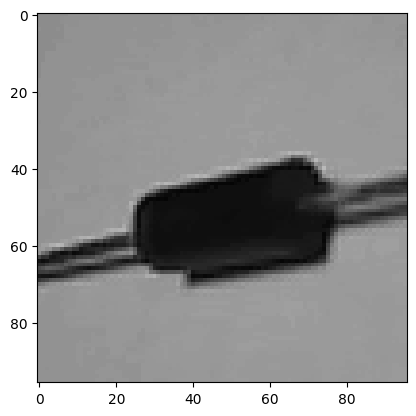

In [7]:
### View one of the training samples

# Chose which sample you want to view
idx = 55

# Print out label (numbe and string) and part of the array
print("Label: " + str(y_train[idx]) + " (" + labels[y_train[idx]] + ")")
print(X_train[idx])

# Display image from array
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)

In [8]:
### Function to resize list of images
def resize_images(images, width, height, anti_aliasing=True):
  """
  Prove a list of Numpy arrays (in images parameter) to have them all resized to desired height and
  width. Returns the list of newly resized image arrays.

  NOTE: skimage resize returns *normalized* image arrays (values between 0..1)
  """
  X_out = []
  for i, img in enumerate(images):
    X_out.append(resize(img, (height, width), anti_aliasing=anti_aliasing))
  return X_out
     

In [9]:
### Scale/crop images

# Resize (scale) all images in the training set
X_train = resize_images(X_train, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the validation set
X_val = resize_images(X_val, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the test set
X_test = resize_images(X_test, TARGET_WIDTH, TARGET_HEIGHT)

Label: 1 (capacitor)
First row: [[0.61300656 0.61301122 0.61567284 0.61568716 0.61578083 0.61886414
  0.62916339 0.63397858 0.63532383 0.63574478 0.63740039 0.63990605
  0.63842706 0.64348612 0.64477119 0.63953106 0.63598509 0.63669703
  0.63539134 0.63506976 0.63158354 0.63480111 0.63533566 0.63529502
  0.63529412 0.63529423 0.63529421 0.63529412]]


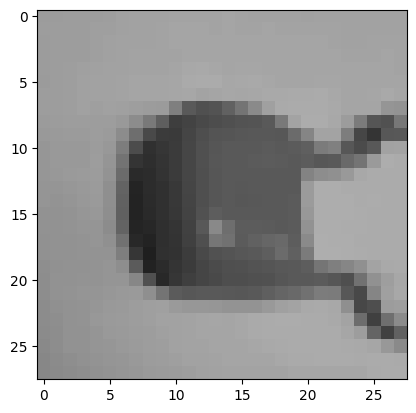

In [10]:
### View training sample again (after they all have been scaled)

# Chose which sample you want to view
idx = 0

# Print out label (numbe and string) and part of the array
print("Label: " + str(y_train[idx]) + " (" + labels[y_train[idx]] + ")")
print("First row:", X_train[idx][:1,:])

# Display image from array (note that images have been normalized)
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=1)

In [11]:
### Convert list of samples and labels into Numpy arrays

# Training set
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# Validation set
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

# Test set
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Print out the new Numpy array shapes (always a good idea to check the shapes!)
print("Training X:", X_train.shape)
print("Training y:", y_train.shape)
print("Validation X:", X_val.shape)
print("Validation y:", y_val.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Training X: (150, 28, 28)
Training y: (150,)
Validation X: (50, 28, 28)
Validation y: (50,)
Test X: (50, 28, 28)
Test y: (50,)


In [12]:
### Flatten each image to a 1D vector (DNN requires 1D input)

# Compute length of 1D array that we will flatten each image to
len_vector = TARGET_WIDTH * TARGET_WIDTH

# Flatten matricies to vectors
X_train = X_train.reshape(num_samples_train, len_vector)
X_val = X_val.reshape(num_samples_val, len_vector)
X_test = X_test.reshape(num_samples_test, len_vector)

# Determine the input shape for our Keras model (must be tuple)
input_shape = (X_train.shape[1],)

# Print out shapes
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X val:", X_val.shape)
print("y val:", y_val.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)
print("Input tensor shape:", input_shape)

X train: (150, 784)
y train: (150,)
X val: (50, 784)
y val: (50,)
X test: (50, 784)
y test: (50,)
Input tensor shape: (784,)


In [13]:
### Convert labels (integers) to one-hot encoding

# Get number of classes
num_classes = len(labels)

# Use Keras's np_utils to create one-hot encoding (note the capital 'Y' - 2D array)
Y_train = utils.to_categorical(y_train, num_classes)
Y_val = utils.to_categorical(y_val, num_classes)
Y_test = utils.to_categorical(y_test, num_classes)

# Print out shapes (capital 'Y' is our one-hot matrix!)
print("Y train:", Y_train.shape)
print("Y val:", Y_val.shape)
print("Y test:", Y_test.shape)

# Print out a few examples from training set
for i in range(10):
  print("Label: " + str(y_train[i]) + " | One-hot:", Y_train[i])
     

Y train: (150, 5)
Y val: (50, 5)
Y test: (50, 5)
Label: 1 | One-hot: [0. 1. 0. 0. 0.]
Label: 1 | One-hot: [0. 1. 0. 0. 0.]
Label: 4 | One-hot: [0. 0. 0. 0. 1.]
Label: 4 | One-hot: [0. 0. 0. 0. 1.]
Label: 4 | One-hot: [0. 0. 0. 0. 1.]
Label: 0 | One-hot: [1. 0. 0. 0. 0.]
Label: 1 | One-hot: [0. 1. 0. 0. 0.]
Label: 2 | One-hot: [0. 0. 1. 0. 0.]
Label: 1 | One-hot: [0. 1. 0. 0. 0.]
Label: 0 | One-hot: [1. 0. 0. 0. 0.]


In [14]:
### Construct Keras model

# A sequential model is a linear stack of layers
model = Sequential()

# First layer: fully-connected with relu activation
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Second layer: fully-connected with relu activation
model.add(Dense(64))   # Input shape is determined automatically from previous layer
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Third layer: 10 nodes, one for each class, and softmax activation
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary
print(model.summary())

/Users/jonastheobald/projects/embedded_computervision/.venv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        50,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,725 (213.77 KB)

 Trainable params: 54,725 (213.77 KB)

 Non-trainable params: 0 (0.00 B)

None


In [15]:
### Train the model
history = model.fit(X_train,
                    Y_train,
                    batch_size=32,
                    epochs=200,
                    verbose=1,
                    validation_data=(X_val, Y_val))

Epoch 1/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - acc: 0.1800 - loss: 1.7305 - val_acc: 0.1600 - val_loss: 1.6635
Epoch 2/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - acc: 0.1867 - loss: 1.6611 - val_acc: 0.2600 - val_loss: 1.5537
Epoch 3/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.2133 - loss: 1.6185 - val_acc: 0.2000 - val_loss: 1.5446
Epoch 4/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.3733 - loss: 1.4982 - val_acc: 0.3200 - val_loss: 1.4732
Epoch 5/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.3600 - loss: 1.4793 - val_acc: 0.5800 - val_loss: 1.4486
Epoch 6/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.3400 - loss: 1.4881 - val_acc: 0.6400 - val_loss: 1.3846
Epoch 7/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.4667 - loss: 1.4443 - val_acc: 0.5000 - val_loss: 1.3136
Epoch 8/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.4400 - loss: 1.3560 - val_acc: 0.5400 - val_loss: 1.2761
Epoch 9/200
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - acc: 0.4467 - loss: 

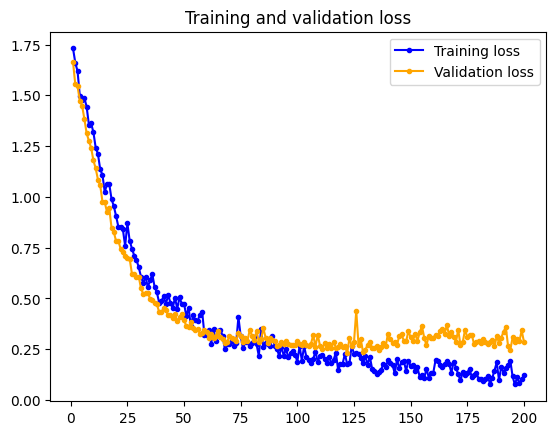

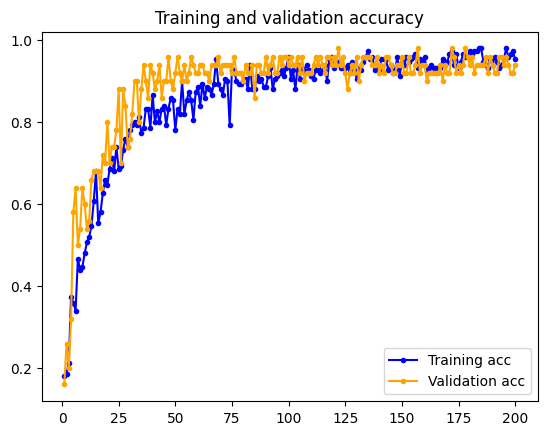

In [16]:
### Plot training and validation accuracy and loss over time

# Extract accuracy and loss values (in list form) from the history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epoch numbers
epochs = range(1, len(acc) + 1)

# Plot training and validation loss values over time
plt.figure()
plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation accuracies over time
plt.figure()
plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [37]:
### Try predicting label with one validation sample (inference)

# Change this to try a different sample from the test set
idx = 49

# Make sample 2D array instead of 1D vector (this is what the Keras model expects as input)
x = np.expand_dims(X_val[idx], 0)

# Make prediction using trained model
y_pred = model.predict(x)

# Find index of highest score in output
predicted_label = np.argmax(y_pred)
actual_label = np.argmax(Y_val[idx])

# Display model output, predicted label, actual label
print("Model output:", y_pred)
print("Predicted label:", predicted_label, "-", labels[predicted_label])
print("Actual label:", actual_label, "-", labels[actual_label])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Model output: [[1.0837699e-04 6.0715061e-05 5.4321628e-02 3.4465727e-03 9.4206274e-01]]
Predicted label: 4 - resistor
Actual label: 4 - resistor


In [38]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
Y_pred = model.predict(X_val)
print("Validation output shape:", Y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val = np.argmax(Y_val, axis=1)
y_pred = np.argmax(Y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val[:50])
print("Predicted validation labels:\t", y_pred[:50])

# Compute confusion matrix (note: we need to transpose SKLearn matrix to make it match Edge Impulse)
cm = confusion_matrix(y_val, y_pred)
cm = np.transpose(cm)

# Print confusion matrix
print()
print(" ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
  print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Validation output shape: (50, 5)
Actual validation labels:	 [1 1 2 1 0 3 4 3 4 0 3 1 1 1 4 0 4 0 4 0 2 2 4 1 2 4 0 4 2 3 3 0 2 0 4 4 3
 0 0 2 2 4 0 1 2 3 0 1 4 4]
Predicted validation labels:	 [1 3 2 1 0 3 2 3 4 0 3 1 1 1 4 0 1 0 4 0 2 2 4 1 2 4 0 4 2 3 3 0 2 0 4 4 3
 0 0 2 2 4 0 1 2 3 0 1 4 4]

 ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)    (3)    (4)   
  background (0):  [    12      0      0      0      0]
   capacitor (1):  [     0      8      0      0      1]
       diode (2):  [     0      0      9      0      1]
         led (3):  [     0      1      0      7      0]
    resistor (4):  [     0      0      0      0     11]


In [39]:
### Evaluate model on validation set
score = model.evaluate(X_val, Y_val)
print("Validation loss:", score[0])
print("Validation accuracy:", score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - acc: 0.9400 - loss: 0.2874
Validation loss: 0.2873656749725342
Validation accuracy: 0.9399999976158142


In [40]:
### Evaluate model on entire test set
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - acc: 0.9600 - loss: 0.0981
Test loss: 0.09807039052248001
Test accuracy: 0.9599999785423279


In [43]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.89      0.89      0.89         9
           2       0.90      1.00      0.95         9
           3       0.88      1.00      0.93         7
           4       1.00      0.85      0.92        13

    accuracy                           0.94        50
   macro avg       0.93      0.95      0.94        50
weighted avg       0.94      0.94      0.94        50



| Class            | Precision | Recall | F1-Score | Support |
| ---------------- | --------- | ------ | -------- | ------- |
| background       | 1.00      | 1.00   | 1.00     | 12      |
| capacitor        | 0.89      | 0.89   | 0.89     | 9       |
| diode            | 0.90      | 1.00   | 0.95     | 9       |
| led              | 0.88      | 1.00   | 0.93     | 7       |
| resistor         | 1.00      | 0.85   | 0.92     | 13      |
| **Accuracy**     |           |        | 0.94     | 50      |
| **Macro Avg**    | 0.93      | 0.95   | 0.94     | 50      |
| **Weighted Avg** | 0.94      | 0.94   | 0.94     | 50      |

### Analysis

* The model achieves **very high performance overall** with 94% accuracy.
* **Background** is classified perfectly (precision, recall, F1 = 1.00).
* **Capacitor** and **LED** classes show slightly lower precision (0.89 and 0.88), indicating occasional false positives.
* **Diode** is very strong: perfect recall (1.00) and high precision (0.90).
* **Resistor** has perfect precision (1.00) but slightly lower recall (0.85), meaning some resistors are missed and classified as another class.
* Macro and weighted averages are balanced, showing no severe class imbalance issues.

👉 In practice, focus on improving recall for **resistor** and precision for **capacitor/LED** to further refine the model.
